# Libraries

In [1]:
!pip install tensorflow keras opencv-python-headless pillow scikit-learn matplotlib

In [2]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, BatchNormalization,
                                     Input, concatenate, add, Conv2D, MaxPooling2D,
                                     ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.metrics import log_loss
import cv2
import os
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import warnings

%matplotlib inline
warnings.simplefilter("ignore", UserWarning)


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rodrigov/deeper1")

print("Path to dataset files:", path)

100%|██████████| 293M/293M [00:04<00:00, 66.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1


# Reading of images and data separation in training and testing

In [5]:
df=pd.read_csv("/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train.truth.csv")
columns=["fn", "label"]

In [6]:
df.head()

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [7]:
# Define the indices for the split
train_df = df[:39117]
valid_df = df[39118:44006]
test_df = df[44007:]  # This part will be used as "test data" instead of a separate test directory.

datagen = ImageDataGenerator(rescale=1./255.)

# /root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train and validation datagen with rescaling (and optional augmentation for training if needed)
datagen = ImageDataGenerator(rescale=1./255.)

# Separate test datagen, only rescaling
test_datagen_final = ImageDataGenerator(rescale=1./255.)

# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",
    x_col="fn",
    y_col="label",
    batch_size=32,
    seed=42,
    classes=['rotated_left', 'rotated_right', 'upright', 'upside_down'],
    shuffle=True,
    class_mode="categorical",
    target_size=(150, 150)
)

# Validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",
    x_col="fn",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    classes=['rotated_left', 'rotated_right', 'upright', 'upside_down'],
    class_mode="categorical",
    target_size=(150, 150)
)

# Test generator (using a portion of train data as test set)
# Test generator (with labels included)
test_generator_final = test_datagen_final.flow_from_dataframe(
    dataframe=test_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",  # Same directory as train
    x_col="fn",   # Image filenames
    y_col="label",  # Labels
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,  # No need to shuffle for test data
    class_mode="categorical"  # Ensure this is set to categorical to return labels
)


Found 39117 validated image filenames belonging to 4 classes.
Found 4888 validated image filenames belonging to 4 classes.
Found 4889 validated image filenames belonging to 4 classes.


In [9]:
dic_name = train_generator.class_indices
dic_name
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']

In [10]:
train_generator.class_indices

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

# Visulizing Cleaned Dataset

rotated_left


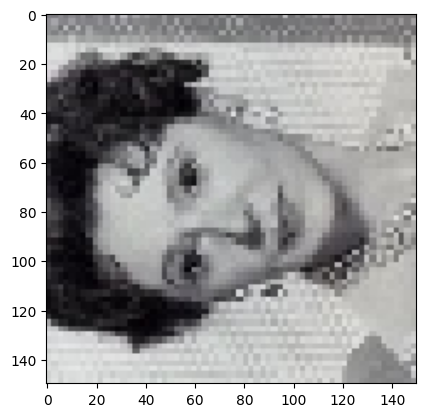

rotated_left


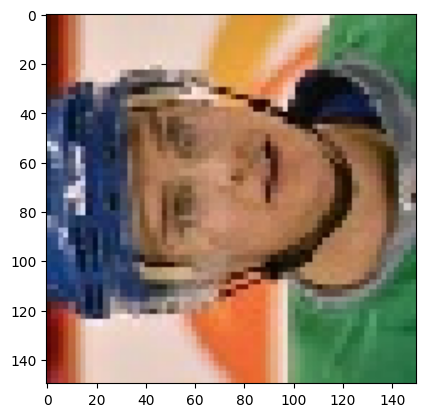

upright


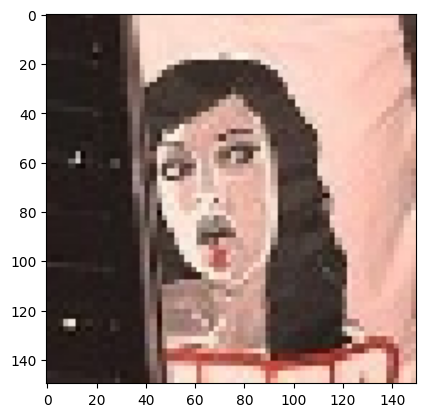

rotated_right


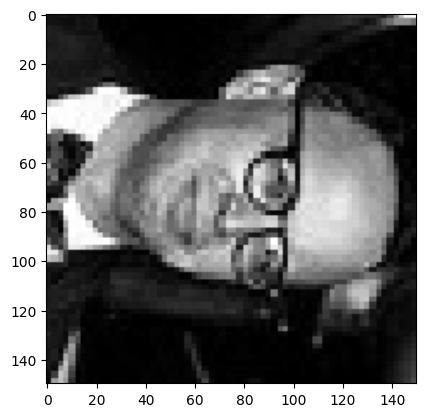

upside_down


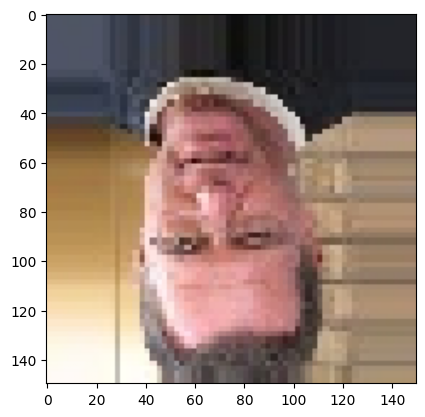

rotated_left


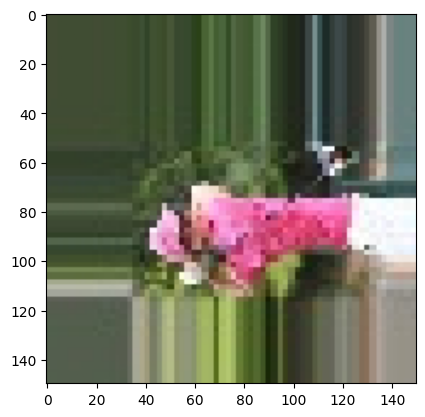

rotated_left


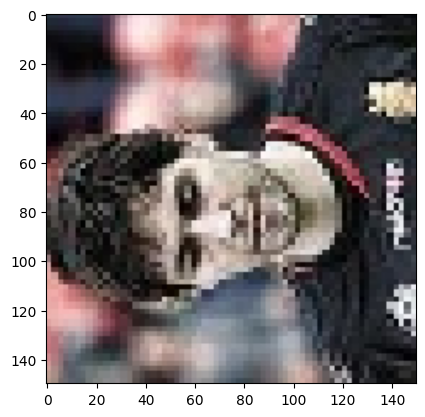

rotated_left


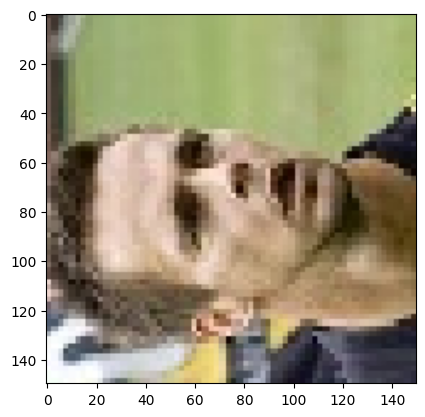

upside_down


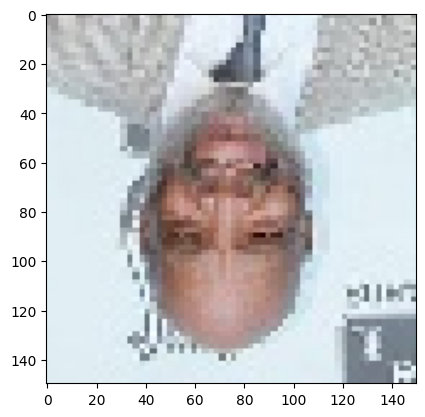

upright


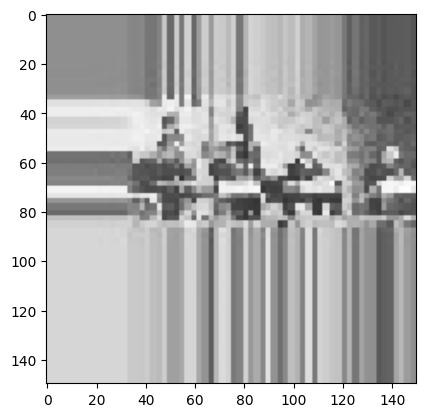

In [11]:
paths = train_generator.filepaths
y_train = train_generator.classes

images = []
i = 0
for path in paths[:10]:
        img_path = path
        img = image.load_img(img_path, target_size=(150,150))
        x = image.img_to_array(img)
        images.append(x/255.)

for I, y in zip(images, y_train[:10] ):
    print(labels[y])
    plt.imshow(I)
    plt.show()

# Inception Network

In [12]:
def create_model_inception():
    input_layer = Input(shape=(150, 150, 3))
    inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)

    x = Flatten()(inception.output)
    x = Dense(256, activation = "relu")(x)
    output_layer = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    return model

In [13]:
# Clear any previous session to avoid state issues
tf.keras.backend.clear_session()

# Now create the model
model_inception = create_model_inception()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,522,660 (101.18 MB)

 Trainable params: 26,488,228 (101.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# Training Inception Model

In [14]:
def train(model, filepath):
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    n_train = 39117
    batch_size = 300
    n_valid = 9779

    try:
        history = model.fit(
            train_generator,
            steps_per_epoch=n_train//batch_size,
            epochs=10,
            validation_data=valid_generator,
            validation_steps=n_valid//batch_size,
            callbacks=callbacks_list
        )
    except Exception as e:
        print(f"Error during training: {e}")
        return None

    # Plot
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    return model

# Training Inception

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.5898 - loss: 0.9272
Epoch 1: val_acc improved from -inf to 0.91699, saving model to inception_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 84s 159ms/step - acc: 0.5911 - loss: 0.9246 - val_acc: 0.9170 - val_loss: 0.2279
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.9313 - loss: 0.1902
Epoch 2: val_acc improved from 0.91699 to 0.93555, saving model to inception_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - acc: 0.9314 - loss: 0.1899 - val_acc: 0.9355 - val_loss: 0.1737
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9699 - loss: 0.0948
Epoch 3: val_acc improved from 0.93555 to 0.95898, saving model to inception_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - acc: 0.9698 - loss: 0.0949 - val_acc: 0.9590 - val_loss: 0.1030
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9730 - loss: 0.0882
Epoch 4: val_acc improved from 0.95898 to 0.97559, saving

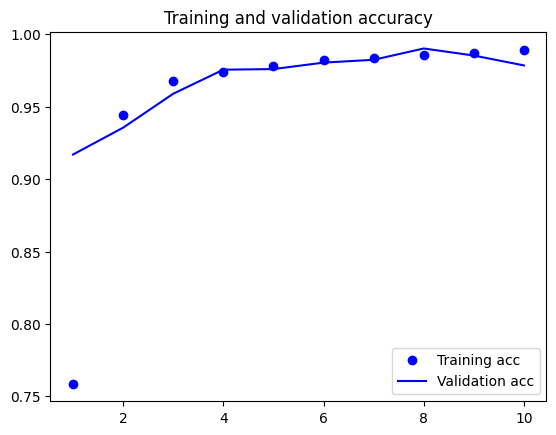

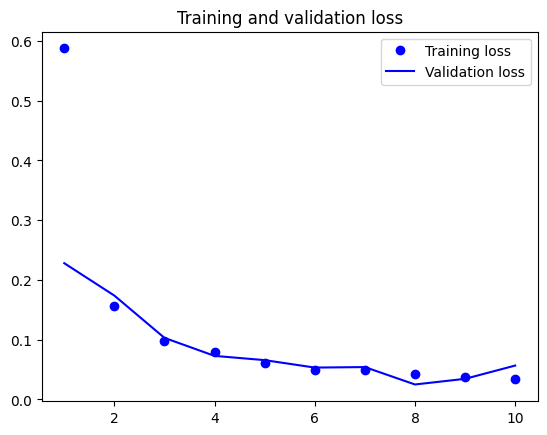

In [15]:
model_inception = train(model_inception, "inception_weights.best.keras")

# Model evaluate

In [16]:
# Evaluate the model using the test generator
model_inception.evaluate(test_generator_final, steps=176, verbose=1)

176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - acc: 0.9791 - loss: 0.0636


[0.05644455924630165, 0.9803640842437744]

In [17]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Predict classes on the test set
y_pred = model_inception.predict(test_generator_final, steps=176, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes from the generator
y_true = test_generator_final.classes

# Get labels list if not already defined (based on model training order)
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']

# Calculate and print accuracy, precision, and recall
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print precision, recall, and F1-score
print(classification_report(y_true, y_pred_classes, target_names=labels))


176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step
Accuracy: 98.04%
               precision    recall  f1-score   support

 rotated_left       0.98      0.98      0.98      1206
rotated_right       0.95      1.00      0.97      1241
      upright       1.00      0.98      0.99      1223
  upside_down       0.99      0.97      0.98      1219

     accuracy                           0.98      4889
    macro avg       0.98      0.98      0.98      4889
 weighted avg       0.98      0.98      0.98      4889



# Prediction for Inception

In [18]:
paths = test_generator_final.filepaths[:30]  # Get the first 30 paths
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']

In [19]:
dic_name

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

In [20]:
y_pred = []
for path in paths:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))  # Load image with the target size
    x = np.reshape(img, [1, 150, 150, 3])  # Reshape for the model input
    x = x / 255.0  # Normalize image to [0, 1]

    # Get prediction probabilities (output shape is (1, 4) for 4 classes)
    preds = model_inception.predict(x)

    # Get the class with the highest probability (argmax)
    predicted_class = np.argmax(preds, axis=-1)[0]  # [0] to get the class label, not the array

    y_pred.append(labels[predicted_class])

# Print or use y_pred as needed
print("Predicted classes for the first 20 images:")
for i, pred in enumerate(y_pred):
    print(f"Image {i + 1}: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

# Visulization of Corrected Predictions and Corrected Images

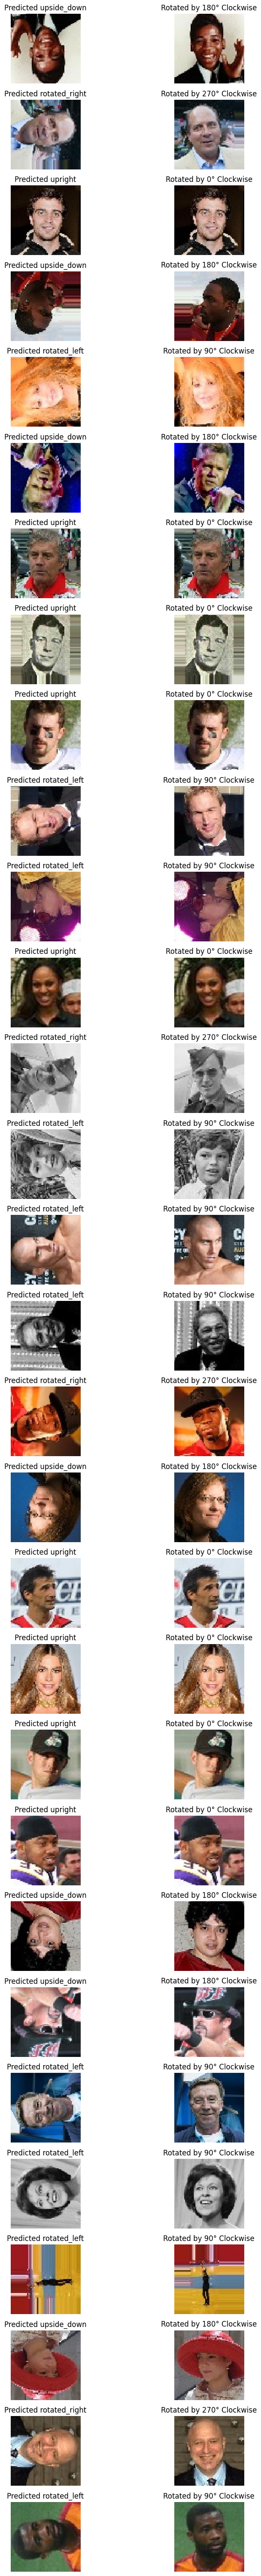

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Assuming you already have paths and y_pred populated (class predictions from the model)
images = []
for path in paths[:30]:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x / 255.)  # Normalize the image

# Map predictions to corresponding rotation angles (clockwise)
rotation_map = {
    'rotated_left': 90,    # Rotate 90 degrees clockwise (left)
    'rotated_right': 270,   # Rotate 270 degrees clockwise (right)
    'upright': 0,          # No rotation
    'upside_down': 180     # Rotate 180 degrees clockwise
}

# Create a subplot layout with 30 rows and 2 columns (for original and rotated images)
fig, axes = plt.subplots(30, 2, figsize=(10, 60))  # 30 rows, 2 columns (adjusted for 30 images)

# Show and rotate images based on predictions
for i, (I, y) in enumerate(zip(images, y_pred[:30])):
    # Get the rotation angle based on the prediction
    rotation_angle = rotation_map[y]

    # Convert the image array back to a PIL image
    pil_img = Image.fromarray((I * 255).astype(np.uint8))

    # Rotate the image as per the predicted orientation (clockwise)
    rotated_img = pil_img.rotate(-rotation_angle)  # Negative for clockwise rotation

    # Display the original image on the left column
    axes[i, 0].imshow(I)
    axes[i, 0].axis('off')  # Hide axes for cleaner display
    axes[i, 0].set_title(f"Predicted {y}")

    # Display the rotated image on the right column
    axes[i, 1].imshow(rotated_img)
    axes[i, 1].axis('off')  # Hide axes for cleaner display
    axes[i, 1].set_title(f"Rotated by {rotation_angle}° Clockwise")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
